This notebook is an example for CustomENet and CustomENetCV. First import these two classes and some other objects.

In [ ]:
from custom_enet import CustomENet, CustomENetCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold

Generate a toy dataset.

In [ ]:
def add_randomness(x, rng, loc=0, scale=1):
    r = rng.normal(loc, scale, size=x.size).reshape(x.shape)
    return x + r

#Simulate X    
nsp = 400 #n_samples
rng = np.random.default_rng(2023)
#Continuous variables:
X1 = rng.uniform(0, 2, nsp * 20).reshape(nsp, -1) 
#Categorical variables:
C1 = rng.integers(0, 3, nsp)
C1 = pd.get_dummies(C1, drop_first=True).to_numpy()
C2 = rng.integers(0, 2, nsp)
C2 = pd.get_dummies(C2, drop_first=True).to_numpy()
C3 = rng.integers(0, 3, nsp)
C3 = pd.get_dummies(C3, drop_first=True).to_numpy()
#Correlated variables as noise.
X2 = add_randomness(X1 ** 2, rng, scale=0.2)
X3 = add_randomness(X1 ** 3, rng, scale=0.2)
X4 = add_randomness(X1 ** 0.5, rng, scale=0.2)
X5 = add_randomness(np.log(X1+1), rng, scale=0.2)
X6 = add_randomness(np.exp(X1-1), rng, scale=0.2)
X7 = add_randomness(np.sin((X1-1)), rng, scale=0.2)
X8 = add_randomness(np.cos((X1-1)), rng, scale=0.2)
X9 = add_randomness(np.sin((X1-1)*2), rng, scale=0.2)
X10 = add_randomness(np.cos((X1-1)*2), rng, scale=0.2)
X11 = add_randomness(np.sin((X1-1)*3), rng, scale=0.2)
X12 = add_randomness(np.cos((X1-1)*3), rng, scale=0.2)
#Combine all
X = np.concatenate([X1, C1, C2, C3, X2, X3, X4, X5, X6, 
                    X7, X8, X9, X10, X11, X12], axis=1)
print(X.shape)

(400, 245)


In [ ]:
#Simulate coefficients
n_dominant = 10 # number of dominant covariates
n_cat = 5 # number of categorical covariates
n_weak = 10 # number of weak covariates
beta = rng.uniform(1, 3, X.shape[1]).reshape(-1, 1) 
beta[n_dominant:(n_dominant+n_weak)] *= 0.1
beta[(n_dominant+n_weak+n_cat):] = .0

In [ ]:
#Simulate y
y_t = X @ beta #deterministic y
y = y_t + rng.normal(0, 2, size = nsp).reshape(-1, 1) #add noise

Assume based on prior knowledge the categorical(dummy) variables have direct relationship with y and we don't want to penalize them. The penalty weight vector can be set as:

In [ ]:
penalty = np.ones(X.shape[1]) 
penalty[(n_dominant+n_weak):(n_dominant+n_weak+n_cat)] = .0

Split into train and test data.

In [ ]:
train_n = 200
X_train, X_test = X[:train_n], X[train_n:]
y_train, y_test = y[:train_n], y[train_n:]
y_t_test = y_t[train_n:]

Create a CV splitter for train data:

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2023)

Theoratically minimal RMSE of prediction:

In [ ]:
print(mean_squared_error(y_test, y_t_test, squared=False))

2.05031561171969


Now let's start regression. First try OLS.

In [ ]:
model_ols = OLS(y_train, add_constant(X_train)).fit()
y_pred = model_ols.predict(add_constant(X_test)).reshape(-1, 1)

Test RMSE of OLS:

In [ ]:
print(mean_squared_error(y_test, y_pred, squared=False))

5.225113897199456


OLS did a bad job due to severe overfitting. This is expected since n_features(125) > n_samples(100). Now try regular Lasso with CV:

In [ ]:
#Sklearn's Lasso requires X to be standardized.
x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(X_train)
X_test_s = x_scaler.transform(X_test)

model_lasso = ElasticNetCV(l1_ratio=1, fit_intercept=True, max_iter=10000, cv=cv, 
                           alphas=None, random_state=2023)
model_lasso.fit(X_train_s, y_train.ravel())

Plot CV errors vs. alphas in train data:

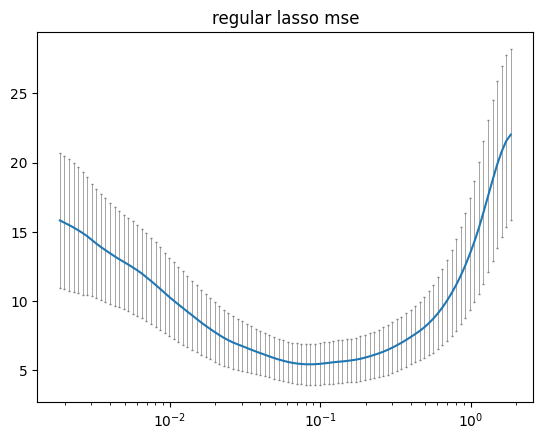

In [ ]:
def path_stats(alphas, cv_errs, plot=True, 
               title=None, figsize=None):
    err_mean = pd.Series(cv_errs.mean(axis=1), index = alphas)
    err_std = pd.Series(cv_errs.std(axis=1), index = alphas)
    if plot:
        plt.figure(figsize=figsize)
        if title:
            plt.title(title)
        err_mean.plot(yerr=err_std, logx=True, 
                      ecolor='grey', elinewidth=0.5, capsize=1)
    return err_mean, err_std

lasso_path_err, _ = path_stats(model_lasso.alphas_, model_lasso.mse_path_, 
                               title='regular lasso mse')

Test RMSE of regular Lasso:

In [ ]:
y_pred = model_lasso.predict(X_test_s).reshape(-1, 1)
print(mean_squared_error(y_test, y_pred, squared=False))

2.5791273808053528


Much better than OLS. Now run Lasso with customized penalties:

In [ ]:
model_cl = CustomENetCV(cv, l1_ratio=1, standardize=True, fit_intercept=True, 
                        alphas=None, tol=1e-4, max_iter=10000, random_state=2023)
model_cl.fit(X_train, y_train, penalty)

CV round 1
CV round 2
CV round 3
CV round 4
CV round 5
CV round 6
CV round 7
CV round 8
CV round 9
CV round 10
CV round 11
CV round 12
CV round 13
CV round 14
CV round 15
CV round 16
CV round 17
CV round 18
CV round 19
CV round 20
CV round 21
CV round 22
CV round 23
CV round 24
CV round 25
CV round 26
CV round 27
CV round 28
CV round 29
CV round 30


Path plot:

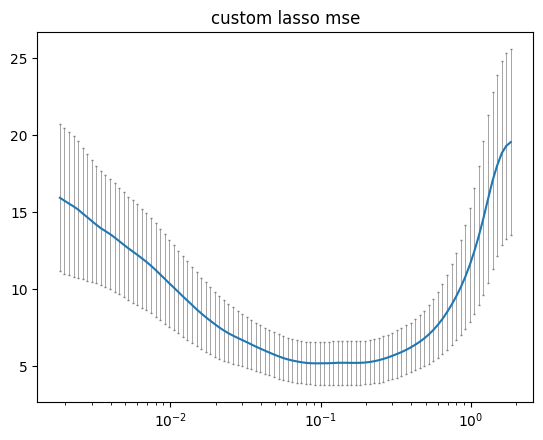

In [ ]:
cl_path_err, _ = path_stats(model_cl.alphas, model_cl.cv_errs, 
                               title='custom lasso mse')

Compare paths of regular Lasso and custom Lasso:

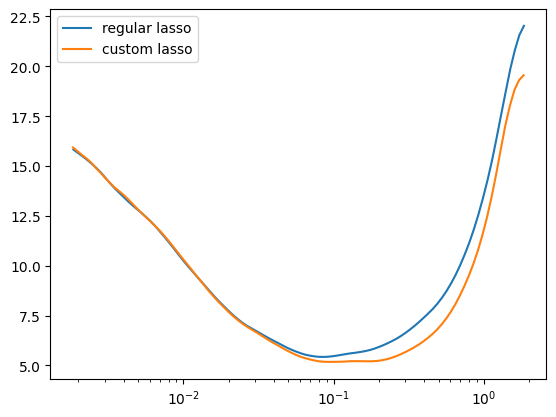

In [ ]:
lasso_path_err.plot(logx=True, label='regular lasso')
cl_path_err.plot(logx=True, label='custom lasso')
plt.legend()

Test RMSE of custom Lasso:

In [ ]:
y_pred = model_cl.predict(X_test).reshape(-1, 1)
print(mean_squared_error(y_test, y_pred, squared=False))

2.5205751542255346


Custom Lasso performed better than regular Lasso as expected. 

Of couse, we don't need to limit the model to Lasso. Let's try ElasticNet with customized penalties and tune the l1_ratio parameter. First generate a rough plot of l1_ratio vs. CV error:

In [ ]:
#Define an objective function
def l1_r_opt_fun(r):
    model = CustomENetCV(cv, alphas=None, l1_ratio=r, standardize=True, 
                         fit_intercept=True, max_iter=10000, refit=False,
                         verbose=False, random_state=2023)
    model.fit(X_train, y_train, penalty)
    return model.cv_min_err

r_v = np.linspace(0.1, 1, 5)
l1_r_errs = []
for i, r in enumerate(r_v):
    print(r)
    l1_r_errs.append(l1_r_opt_fun(r))

0.1
0.325
0.55
0.775
1.0


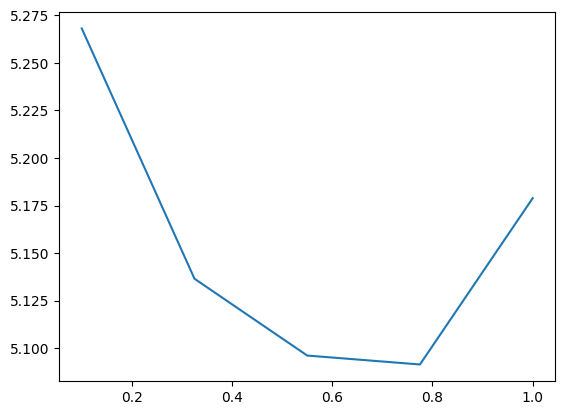

In [ ]:
plt.plot(r_v, l1_r_errs)

Seems like the optimal value is around 0.8. Further zoom in:

0.5
0.6
0.7
0.8
0.9
1.0


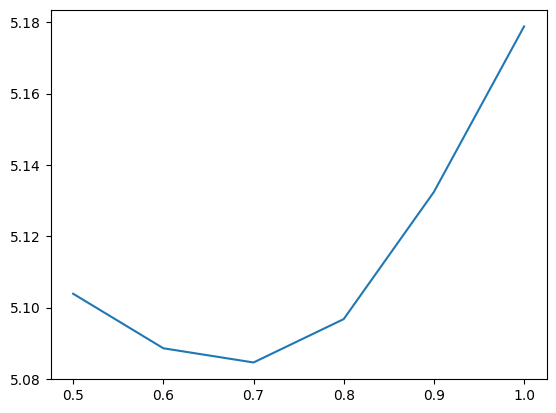

In [ ]:
r_v = np.linspace(0.5, 1, 6)
l1_r_errs = []
for i, r in enumerate(r_v):
    print(r)
    l1_r_errs.append(l1_r_opt_fun(r))

plt.plot(r_v, l1_r_errs)

It's clear the optimal value lies between 0.6 and 0.8. Finally we can fine-tune l1_ratio by optimization algorithm (this may take a while):

In [ ]:
ce_opt_res = minimize_scalar(l1_r_opt_fun, bounds = (.6, .8), tol=1e-4, 
                             options={'maxiter':100, 'disp':True})
l1_r_best = ce_opt_res.x
print(l1_r_best)

/usr/local/lib/python3.9/dist-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "



Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.0001 )
0.6645052789645336


Use the optimal l1_ratio to fit the custom ElasticNet model:

In [ ]:
model_ce = CustomENetCV(cv, l1_ratio=l1_r_best, standardize=True, fit_intercept=True, 
                        alphas=None, tol=1e-4, max_iter=10000, random_state=2023)
model_ce.fit(X_train, y_train, penalty)

CV round 1
CV round 2
CV round 3
CV round 4
CV round 5
CV round 6
CV round 7
CV round 8
CV round 9
CV round 10
CV round 11
CV round 12
CV round 13
CV round 14
CV round 15
CV round 16
CV round 17
CV round 18
CV round 19
CV round 20
CV round 21
CV round 22
CV round 23
CV round 24
CV round 25
CV round 26
CV round 27
CV round 28
CV round 29
CV round 30


Test RMSE:

In [ ]:
y_pred = model_ce.predict(X_test).reshape(-1, 1)
print(mean_squared_error(y_test, y_pred, squared=False))

2.4728960379551017


Customized penalty allows you to suppress certain variables. We first plot the the coefficients of the model:

<BarContainer object of 245 artists>

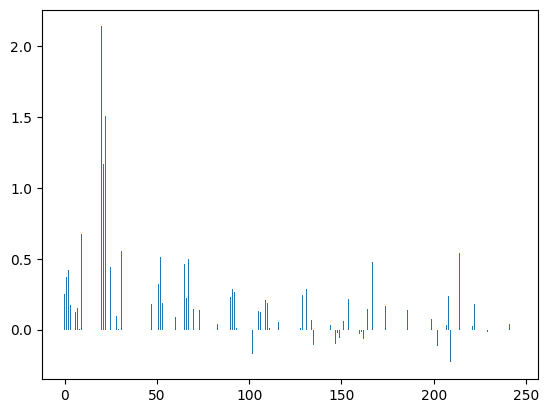

In [ ]:
xtks = np.arange(X.shape[1])
plt.bar(xtks, model_ce.w[:-1], width=0.4)

Suppose we want to suppress variables after 40, we can do:

<BarContainer object of 245 artists>

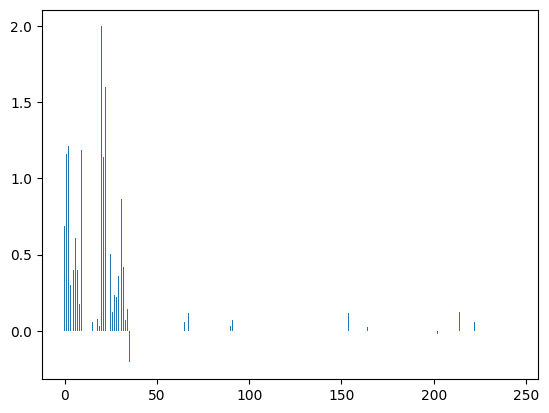

In [ ]:
new_penalty = penalty.copy()
new_penalty[40:] = 2

model_ce_new = CustomENet(alpha=model_ce.alpha_best, l1_ratio=l1_r_best, standardize=True, fit_intercept=True, tol=1e-4, max_iter=10000, random_state=2023)
model_ce_new.fit(X_train, y_train, new_penalty)
plt.bar(xtks, model_ce_new.w[:-1], width=0.4)

Setting the penalty to infinite literally means to set the coefficient to 0.

<BarContainer object of 245 artists>

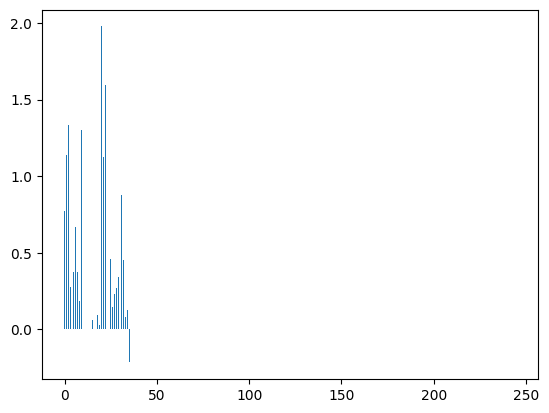

In [ ]:
new_penalty = penalty.copy()
new_penalty[40:] = np.inf

model_ce_new = CustomENet(alpha=model_ce.alpha_best, l1_ratio=l1_r_best, standardize=True, fit_intercept=True, tol=1e-4, max_iter=10000, random_state=2023)
model_ce_new.fit(X_train, y_train, new_penalty)
plt.bar(xtks, model_ce_new.w[:-1], width=0.4)

In contrast to sklearn's ElasticNet, CustomENet and CustomENet incorporate Ridge regression. Simply set l1_ratio to 0. But for Ridge you need to provide the alphas.

In [ ]:
alphas = np.geomspace(0.01, 10, num=100)
model_rd = CustomENetCV(cv, l1_ratio=0, standardize=True, fit_intercept=True, 
                        alphas=alphas, tol=1e-4, max_iter=10000, random_state=2023)
model_rd.fit(X_train, y_train, penalty)

CV round 1
CV round 2
CV round 3
CV round 4
CV round 5
CV round 6
CV round 7
CV round 8
CV round 9
CV round 10
CV round 11
CV round 12
CV round 13
CV round 14
CV round 15
CV round 16
CV round 17
CV round 18
CV round 19
CV round 20
CV round 21
CV round 22
CV round 23
CV round 24
CV round 25
CV round 26
CV round 27
CV round 28
CV round 29
CV round 30


Path plot of Ridge:

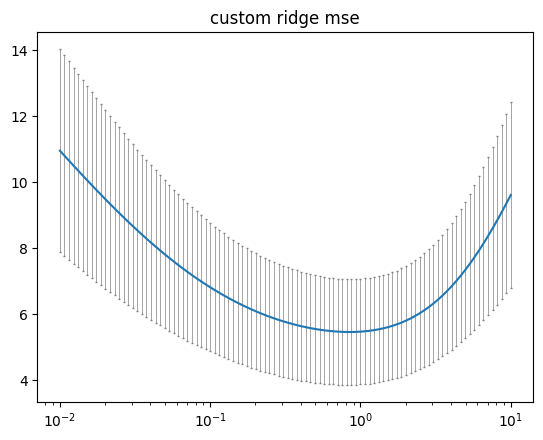

In [ ]:
 _ = path_stats(model_rd.alphas, model_rd.cv_errs, title='custom ridge mse')